In [1]:
import mujoco
import mujoco_viewer
import random
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:

height = 480
width = height

model = mujoco.MjModel.from_xml_path("/home/luangb/Documents/TCC/Kuka_RL_Control/environment.xml")
data = mujoco.MjData(model)
viewer = mujoco_viewer.MujocoViewer(model, data,"offscreen",width=width,height=height)
mujoco.mj_forward(model, data)
img,depth = viewer.read_pixels(camid=0,depth=True)

# Get the distances to the near and far clipping planes.
extent = model.stat.extent
near = model.vis.map.znear  * extent
far = model.vis.map.zfar * extent
# Convert from [0 1] to depth in meters, see links below:
# http://stackoverflow.com/a/6657284/1461210
# https://www.khronos.org/opengl/wiki/Depth_Buffer_Precision
depth_meters = near / (1 - depth * (1 - near / far))



array([ 3.32, -0.97,  0.9 ])

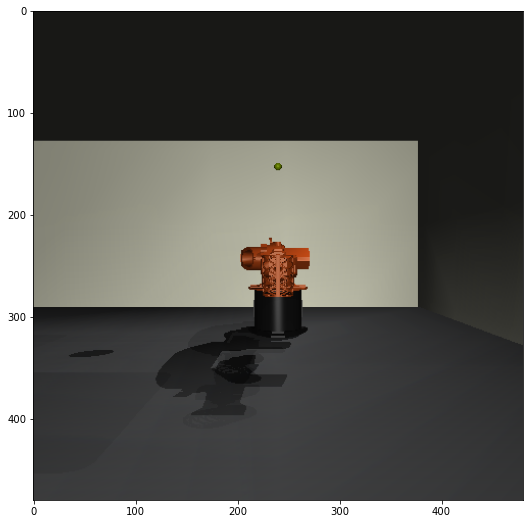

In [3]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(img)
model.stat.center


array([ 3.32, -0.97,  0.9 ])

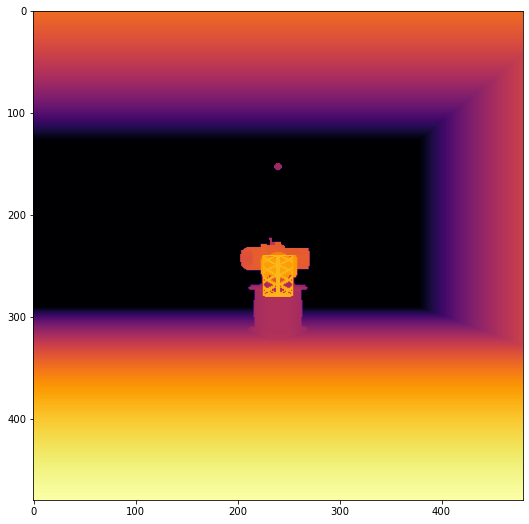

In [4]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.imshow(-depth_meters,cmap="inferno")
model.stat.center

In [5]:
def px2meters(H_inv, p, depth):
    """Converts a pixel coordinate to a 3D point in meters."""
    p = np.array([[p[0]], [p[1]], [1.0],[1.0/depth]])
    p = depth * H_inv @ p 
    return p[:3]

fy = 0.5 * height / np.tan(model.camera("depth_camera0").fovy[0] * np.pi / 360)
fx = 0.5 * width / np.tan(model.camera("depth_camera0").fovy[0] * np.pi / 360)
K = np.array(((fx, 0, width / 2), (0, fy, height / 2), (0, 0, 1)), dtype=np.float32)

import itertools


# R = np.array([[0., 0., 1.], [1., 0., 0.], [0., 1., 0.]])
R = np.array([ [0., 0., -1.], [0., 1., 0.],[-1., 0., 0.]])

    
t = np.array([[0.7],[ 0. ],[4. ]])
Rt = np.concatenate((R, t), axis=1)


K_fr = np.eye(4, dtype=np.float32)
K_fr[:3,:3] = K
Rt_fr = np.eye(4, dtype=np.float32)
Rt_fr[:3,:4] = Rt


H_inv = np.linalg.inv(K_fr @ Rt_fr)
    
real_coords = np.array([px2meters(H_inv,(i,j),depth_meters[i,j][0]) for i in range(0,depth_meters.shape[0]) for j in range(0,depth_meters.shape[1])]).reshape((width,height,3))



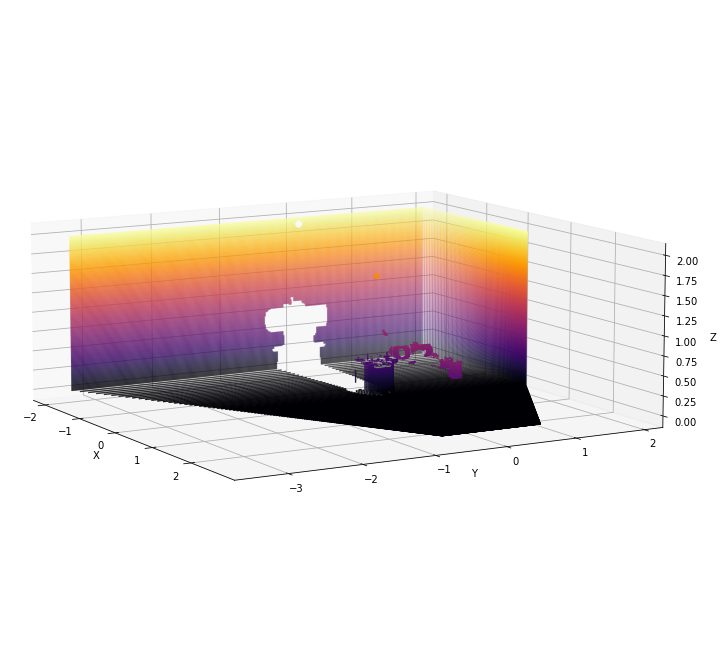

In [7]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10,-30)
real_coordsp = real_coords[real_coords[:,:,2]<2]
x,y,z = real_coordsp[:,0],real_coordsp[:,1],real_coordsp[:,2]
ax.scatter(x,y,z, c=z,s=1, cmap='inferno', linewidth=0.5)
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xlim(-2.1,2.1)
# ax.set_ylim(-3.1,3.1)
# ax.set_zlim(0,2.1) 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title(f"R = {R}")
plt.show()


In [15]:
type(data.solver_iter)

int

In [16]:

np.deg2rad(model.camera("depth_camera0").fovy[0])


1.0122909661567112

In [17]:
# filter color 
# It converts the BGR color space of image to HSV color space
def find_circles():
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
    # Threshold of blue in HSV space
    d = 10


    lower_blue = np.array([(72-d)//2, 10*2.55//1, 10*2.55//1])
    upper_blue = np.array([(72+d)//2, 100*2.55//1, 100*2.55//1])

    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    result = cv2.bitwise_and(img, img, mask = mask)

    blur = cv2.GaussianBlur(result,(5,5),0)
    gray = cv2.cvtColor(blur, cv2.COLOR_RGB2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=379, param2=11, minRadius=0, maxRadius=0)
    plt.imshow(img)
    plt.scatter(circles[0,:,0],circles[0,:,1])





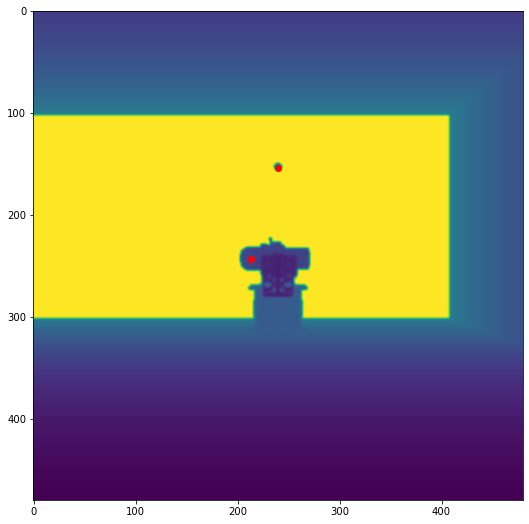

[[213.5 243.5  11. ]
 [239.5 153.5   3.8]]
[array([ 0.84371734, -0.19682502,  0.67813064]), array([ 0.0328958 , -0.00916261,  1.49713829])]


In [18]:
depth_img = np.copy(depth_meters)
# depth_img[depth_img<1] = 10
depth_img[depth_img>=4.9] = 10
depth_img = ((depth_img/depth_img.max())*255).astype(np.uint8)
#find circles

blur = cv2.GaussianBlur(depth_img,(5,5),0)

circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, 20, param1=500, param2=16, minRadius=0, maxRadius=0)
if circles is not None :
    fig=plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    ax.imshow(blur)
    for circle in circles[0]:
        x,y,r = circle
        ax.scatter(x,y,c="r")
    plt.show()
    print(circles[0])
    print([real_coords[int(y),int(x)] for x,y,_ in circles[0]])


In [19]:
array([[[24, 24, 22],
        [24, 24, 22],
        [24, 24, 22],
        ...,
        [24, 24, 22],
        [24, 24, 22],
        [24, 24, 22]],

       [[24, 24, 22],
        [24, 24, 22],
        [24, 24, 22],
        ...,
        [24, 24, 22],
        [24, 24, 22],
        [24, 24, 22]],

       [[24, 24, 22],
        [24, 24, 22],
        [24, 24, 22],
        ...,
        [24, 24, 22],
        [24, 24, 22],
        [24, 24, 22]],

       ...,

       [[47, 48, 48],
        [48, 48, 48],
        [48, 48, 48],
        ...,
        [41, 41, 41],
        [40, 41, 41],
        [40, 41, 41]],

       [[48, 48, 48],
        [48, 48, 48],
        [48, 48, 48],
        ...,
        [40, 41, 41],
        [40, 41, 41],
        [40, 41, 41]],

       [[48, 48, 48],
        [48, 48, 48],
        [48, 48, 48],
        ...,
        [40, 41, 42],
        [40, 41, 42],
        [40, 41, 42]]], dtype=uint8)

array([[[213.5, 243.5,  11. ],
        [239.5, 153.5,   3.8]]], dtype=float32)

In [17]:
stripe = depth_img[:,20]
np.where(stripe == 255)

(array([103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280

In [18]:
# plt.imshow(depth_img)
real_coords[302,20]
1.78551832

1.78551832

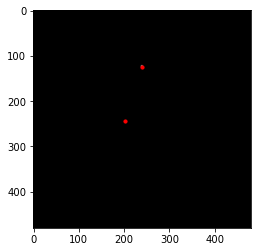

In [23]:
#draw the ball
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        plt.scatter(i[0],i[1],c="r",s=10)
plt.imshow(gray,cmap="gray")

In [24]:
color = np.array((0.8, 1, 0))*255
#color hex
color = color.astype(np.uint8)
[hex(x) for x in color]

['0xcc', '0xff', '0x0']

In [25]:
def step_input(model,data):
    mujoco.mj_resetData(model, data)

    
    data.actuator("a1_intvel").ctrl = -2.9
    result = {"qpos":[data.joint("joint_a1").qpos[0]], "qvel":[data.joint("joint_a1").qvel[0]], "ctrlvel":[data.ctrl[0]], "time":[data.time]}
    start = time.time()
    while data.time < 2.5:
        mujoco.mj_step(model,data)
        result["qpos"].append(data.qpos[0])
        result["qvel"].append(data.qvel[0])
        result["ctrlvel"].append(data.actuator("a1_intvel").ctrl[0])
        result["time"].append(data.time)
        if data.ctrl[0] and data.qpos[0] <= -2:
            data.actuator("a1_intvel").ctrl = 0.0


    end = time.time()
    # print("time: ", end-start)
    return result


In [ ]:
viewer.sa
    

In [32]:
px=(20,20)
img[px]

array([24, 24, 22], dtype=uint8)

In [ ]:
def test_values(kp, plot=False):
    set_kp(kp)
    model = mujoco.MjModel.from_xml_path("/home/luangb/Documents/TCC/Kuka_RL_Control/environment.xml")
    data = mujoco.MjData(model)
    result = step_input(model,data)
    if plot:
        plt.plot(result["time"], result["qpos"], label="qpos")
        # plt.plot(result["time"], result["qvel"], label="qvel")
        # plt.plot(result["time"], result["ctrlpos"], label="ctrlpos")
        plt.plot(result["time"], result["ctrlvel"], label="ctrlvel")
        plt.grid()
        print("last_pos", result["qpos"][-1])
        plt.legend()
        plt.show()
        viewer = mujoco_viewer.MujocoViewer(model, data,"offscreen")
        mujoco.mj_forward(model, data)
        img = viewer.read_pixels(camid=0)
        plt.imshow(img)
    return result


    
    

last_pos -2.001194520335802


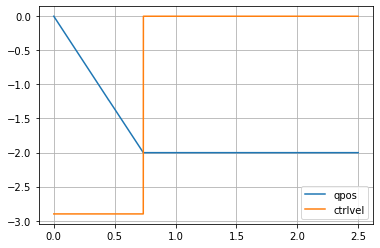

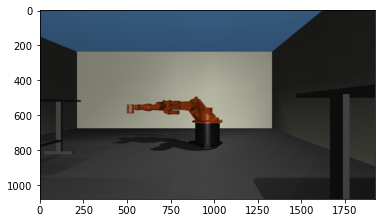

In [ ]:
r=test_values(1000000,True)

In [ ]:
ss_pos = r["qpos"][400:-1]
mujoco.

In [ ]:
(max(ss_pos)-min(ss_pos))/np.pi * 180

15.628135725609786

In [ ]:
def test_best_kp():
    kp_list = np.linspace(100000, 1000000, 200)
    result = []
    for kp in kp_list:
        r = test_values(kp)
        ss_pos = r["qpos"][len(r["qpos"])//3:-1]
        result.append((max(ss_pos)-min(ss_pos))/np.pi * 180)
        # print(kp, result[-1])
    plt.plot(kp_list, result)
    plt.grid()
    plt.show()
    return result

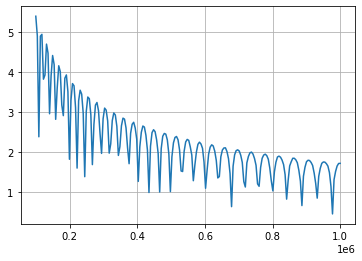

128 0.45078289898337165


34673.366834170854

In [ ]:
deviations = test_best_kp()
deviations = deviations[len(deviations)//3:-1]
print(np.argmin(deviations), np.min(deviations))
np.linspace(0, 50000, 200)[10:-1][np.argmin(deviations)]

In [ ]:
cam=model.cam("depth_camera0")

In [ ]:
mujoco.mjv_makeScene(model, data, 0)

AttributeError: module 'mujoco' has no attribute 'mjv_makeScene'

In [ ]:
ctx=mujoco.GLContext(1920, 1080)

In [ ]:
ctx.make_current()

In [ ]:
scn=mujoco.MjvScene(model,1000)

In [ ]:
mujoco.update_scene(model, data, scn, cam)

AttributeError: module 'mujoco' has no attribute 'update_scene'

In [ ]:
opt=mujoco.MjvOption()
mujoco.mjv_updateScene(model, data,opt,None,cam,1,scn)


TypeError: mjv_updateScene(): incompatible function arguments. The following argument types are supported:
    1. (m: mujoco._structs.MjModel, d: mujoco._structs.MjData, opt: mujoco._structs.MjvOption, pert: Optional[mujoco._structs.MjvPerturb], cam: mujoco._structs.MjvCamera, catmask: int, scn: mujoco._structs.MjvScene) -> None

Invoked with: <mujoco._structs.MjModel object at 0x7f49f2755770>, <mujoco._structs.MjData object at 0x7f49f256b970>, <MjvOption
  actuatorgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  flags: array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1], dtype=uint8)
  frame: 0
  geomgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  jointgroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  label: 0
  sitegroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  skingroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
  tendongroup: array([1, 1, 1, 0, 0, 0], dtype=uint8)
>, None, <_MjModelCameraViews
  bodyid: array([0], dtype=int32)
  fovy: array([58.])
  id: 0
  ipd: array([0.05])
  mat0: array([0., 0., 1., 1., 0., 0., 0., 1., 0.])
  mode: array([0], dtype=int32)
  name: 'depth_camera0'
  pos: array([3. , 0. , 0.7])
  pos0: array([3. , 0. , 0.7])
  poscom0: array([2.69367578, 0.01172623, 0.28206348])
  quat: array([0.5, 0.5, 0.5, 0.5])
  targetbodyid: array([-1], dtype=int32)
  user: array([], dtype=float64)
>, 1, <mujoco._structs.MjvScene object at 0x7f49f23b1670>

In [131]:
R = np.array([[  0.0000000,  1.0000000,  0.0000000],[0.0000000,  0.0000000,  1.0000000],[1.0000000,  0.0000000,  0.0000000 ]])

In [132]:
np.linalg.inv(R)

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [146]:
depth_meters[0,0][0]

2.8021276

In [16]:
depth[20,30]

NameError: name 'depth' is not defined

In [11]:
class person:
    def __init__(self, name, age):
        self._name = name
        self._age = age

    def __repr__(self):
        return f"Name: {self._name}, Age: {self._age}"

    @property
    def age(self):
        return self._age
    
    @age.setter
    def age(self, age):
        if age < 0:
            raise ValueError("Age must be positive")
        self._age = age
    
    

In [12]:
a = person("luan", 20)

In [13]:
a

Name: luan, Age: 20

In [14]:
a.age = 30

In [1]:
from handlers import *


In [2]:
sim = MujocoHandler("/home/luangb/Documents/TCC/Kuka_RL_Control/environment.xml")
cam = RGBD_CamHandler(sim,size=600,windowed=False,fps=30)
cam.R = np.array([ [0., 0., -1.], [0., 1., 0.],[-1., 0., 0.]])
cam.t = np.array([[0.7],[ 0. ],[4. ]])


In [3]:
sim.reset()
sim.set_random_state()
tracker = BallTracker(cam)

In [5]:
tracker._Kalman.predict()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [11]:
from filterpy.common import Q_discrete_white_noise
f = Q_discrete_white_noise(dim=3, dt=0.32, var=0.13)

In [17]:
dt = 1/60
half_dt_squared = 0.5 * dt * dt

Tau = np.array([half_dt_squared, half_dt_squared, half_dt_squared, dt, dt, dt, 1, 1, 1], dtype=np.float32).reshape((9,1))
var = 100
Q = Tau * var* Tau.T

In [19]:
Q.shape

(9, 9)